# Imports

In [32]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import numpy as np
import numpy.linalg as npla
import sys
import argparse

import cv2
np.set_printoptions(precision=4)

## Helper functions

## Zoey's Homography funct

In [59]:
def build_matrix(coordinates_d, coordinates_s):
    num_points = len(coordinates_d)
    matrix_size = num_points * 2
    A = np.zeros((matrix_size, 9))
    for i in range(len(coordinates_d)):
        curr_d = coordinates_d[i][0]
        curr_s = coordinates_s[i][0]
        A[2*i,0] = curr_d[0]
        A[2*i,1] = curr_d[1]
        A[2*i,2] = 1
        A[2*i,6] = -1 * curr_d[0] * curr_s[0]
        A[2*i,7] = -1 * curr_d[0] * curr_s[1]
        A[2*i,8] = -1 * curr_d[0]
        A[2*i+1,3] = curr_s[0]
        A[2*i+1,4] = curr_s[1]
        A[2*i+1,5] = 1
        A[2*i+1,6] = -1 * curr_d[1] * curr_s[0]
        A[2*i+1,7] = -1 * curr_d[1] * curr_s[1]
        A[2*i+1,8] = -1 * curr_d[1]
        
    return A

def homography(coordinates_d, coordinates_s):
    A = build_matrix(coordinates_d, coordinates_s)
    values, vec = npla.eigh(A.T @ A)
    min_eig = values.min()
    vector = vec[np.where(values == values.min())]
    vector = np.reshape(vector, (3,3))
    
    return vector

In [34]:
def openImage(imgname):
    """
    Opens an image file and returns the image object.

    Parameters:
    imgname (str): The path to the image file.

    Returns:
    numpy.ndarray: The image object.

    """
    img = cv2.imread(imgname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [35]:
def calculate_accuracy(matches, imageKeyPoints, warpedImageKeyPoints, H):
  """
  Calculates the accuracy of the matches given key points from the original
  image, and the original image warped by the homography matrix H (using SIFT).
  Compares the warped keypoint to the image keypoint (that gets warped by H) to
  see if it is within a 3-pixel square neighborhood.

  Parameters:
  matches (cv.DMatches): The matches calculated by Brute Force match.
  imageKeyPoints (cv.KeyPoint): The original image keypoints computed by
  sift.detectAndCompute.
  warpedImageKeyPoints (cv.KeyPoint): The keypoints of the warped image computed
  by sift.detectAndCompute.
  H (np.array): 3x3 Homography matrix.

  Returns:
  int: Accuracy of the matches
  """
  hits = 0
  for eachMatch in matches:
    imageKeyPoint = imageKeyPoints[eachMatch.queryIdx].pt
    warpedKeyPoint = warpedImageKeyPoints[eachMatch.trainIdx].pt
    homogenousImageKeyPoint = np.array([imageKeyPoint[0], imageKeyPoint[1], 1])
    warpedImagePoint = H @ homogenousImageKeyPoint
    warpedImagePoint = warpedImagePoint/warpedImagePoint[2]
    warpedImagePoint = warpedImagePoint[:2]

    if np.abs(warpedImagePoint[0] - warpedKeyPoint[0]) <= 3 and np.abs(warpedImagePoint[1] - warpedKeyPoint[1]) <= 3:
      hits += 1
  return hits/len(matches)

In [36]:
def computeMatches(img1, img2, img3):
  """
  Computes the keypoints of img1, img2, img3 using sift.detectAndCompute. Then,
  matches keypoints in img1 and img2. Also matches keypoints in img2 and img3.

  Parameters:
  img1 (np.array): First image.
  img2 (np.array): Second image.
  img3 (np.array): Third image.

  Returns:
  keypointList (list[cv.KeyPoints]): List of keypoints. keypointList[0] stores
  img1 keypoints, etc.
  matches12 (cv.DMatch): Matches of img1 and img2 keypoints.
  matches23 (cv.DMatch): Matches of img2 and img3 keypoints.
  """
  keypointList = []
  descriptorList = []

  sift = cv2.SIFT_create()

  for img in [img1,img2,img3]:
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(grayImage, None)
    keypointList.append(kp)
    descriptorList.append(des)


  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  matches12 = bf.match(descriptorList[0],descriptorList[1])
  matches23 = bf.match(descriptorList[1],descriptorList[2])

  matches12 = sorted(matches12, key = lambda x:x.distance)
  matches23 = sorted(matches23, key = lambda x:x.distance)
  return keypointList, matches12, matches23

# Question 1

Open the image, initialize the H matrix

In [5]:
image = openImage("IMG_8833.JPG")
H = np.array([[1.5, 0.5, 0], [0,2.5,0], [0,0,1]])
length, width, channels = image.shape

Use H matrix to warp the image.

In [6]:
warpedImage = cv2.warpPerspective(image, H, (length*2, width*2))
sift = cv2.SIFT_create()

Use sift.detectAndCompute to compute the keypoints. It takes a grayscale image, and uses Scale Invariant Feature Transform to identify keypoints.

It does this by using Difference of Gaussians (DoG) to find points of interest, then uses keypoint localization (similar to Harris Corner Detection) to discard some of the points of interest that are not corners or sufficiently intense.

Then, it assigns orientation of the keypoint by taking a neighborhood, calculating the gradient of the point, and calculating the magnitude and direction. It adds all the directions to a histogram, weighed with the magnitude. Then, it chooses the direction with the highest magnitude. This guarantees rotation invariance.

Finally, it creates the keypoint descriptors.

In [7]:
grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
imageKeyPoints, des = sift.detectAndCompute(grayImage,None)

Brute force matches the keypoints by calculating the euclidean distance between each of the image keypoints and warpedImage keypoints, and selecting the image keypoint and warpedImage keypoint that has the smallest distance.

In [8]:
grayWarpedImage = cv2.cvtColor(warpedImage, cv2.COLOR_RGB2GRAY)
warpedImageKeyPoints, warpDes = sift.detectAndCompute(grayWarpedImage, None)

In [9]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des,warpDes)
matches = sorted(matches, key = lambda x:x.distance)

Calculate accuracy

In [10]:
acc = calculate_accuracy(matches, imageKeyPoints, warpedImageKeyPoints, H)
print(acc)

0.503566005613583


Its interesting to see that even for such a well-known algorithm, the accuracy is not that great.

# Question 2

Open the images

In [37]:
img1 = openImage("IMG_8833.JPG")
img2 = openImage("IMG_8834.JPG")
img3 = openImage("IMG_8835.JPG")

Triple the width of each image, so it's easy to stitch all the images together. The image isn't being resized, it is simple being placed on a bigger canvas

In [38]:
img1Bigger = np.zeros((img1.shape[0], img1.shape[1]*3, img1.shape[2]), dtype=np.uint8)
img2Bigger = np.zeros((img2.shape[0], img2.shape[1]*3, img2.shape[2]), dtype=np.uint8)
img3Bigger = np.zeros((img3.shape[0], img3.shape[1]*3, img3.shape[2]), dtype=np.uint8)

In [39]:
img1Bigger[:, :img1.shape[1], :] = img1
img2Bigger[:, img1.shape[1]:img1.shape[1]*2, :] = img2
img3Bigger[:, img1.shape[1]*2:, :] = img3

In [40]:
img1 = img1Bigger
img2 = img2Bigger
img3 = img3Bigger

Find the keypoints of each image, and then compute the keypoint matches of img1 and img2, as well as img2 and img3

In [9]:
kpList, match1, match2 = computeMatches(img1, img2, img3)

In [41]:
match1 = sorted(match1, key = lambda x:x.distance)
match2 = sorted(match2, key = lambda x:x.distance)

Get the matching keypoints for img1 and img2

In [56]:
img1toimg2keyPoints = np.array([list(kpList[0][eachMatch.queryIdx].pt) for eachMatch in match1[:200]]).reshape(-1,1, 2)

In [57]:
img2keyPoints = np.array([list(kpList[1][eachMatch.trainIdx].pt) for eachMatch in match1[:200]]).reshape(-1, 1, 2)

In [58]:
print(img1toimg2keyPoints[0])
# print(img2keyPoints)

[[2690.0566 1513.0066]]


Find the homography matrix between img1 and img2 based on the matching img1 and img2 keypoints. This is done using the RANSAC algorithm.

The RANSAC algorithm works in the following way:
1. Choose a subset of the keypoints, called the 'consensus set'.
2. Compute the homography matrix.
3. Calculate loss of keypoints not included in the original subset, based on the computed homography matrix .
4. Include keypoints that have a small enough loss in the 'consensus set'.
5. If enough keypoint are now in the consensus set, calculate a new matrix based on all the points in the consensus set.
6. Check if this is better than the original matrix.
7. Repeat this k times

In [61]:
H = homography(img1toimg2keyPoints, img2keyPoints)
H2 = cv2.findHomography(img1toimg2keyPoints, img2keyPoints, cv2.RANSAC, 5.0)[0]

In [62]:
length, width, channels = img1.shape
print(H)
print(H2)

[[-1.9917e-05 -2.2126e-04  5.7974e-01]
 [-4.1460e-01 -4.3319e-02  6.4620e-01]
 [-2.6936e-01 -3.2440e-05 -1.2945e-04]]
[[ 5.1787e+00 -3.8634e-01 -2.1309e+03]
 [ 1.0346e+00  2.5010e+00 -3.0792e+03]
 [ 5.2507e-04 -1.9969e-05  1.0000e+00]]


## Warp Perspective function implemented by Madelyn

In [63]:
# Define the warp perspective function
def warp_perspective(image, H, dsize):
    """
    Warp an image using a given homography matrix H.

    :param image: Input image to be warped.
    :param H: Homography matrix.
    :param dsize: Size of the output image (width, height).
    :return: Warped image.
    """
    warped_image = np.zeros((dsize[1], dsize[0], 3), dtype=np.uint8)  # Output image
    for y in range(dsize[1]):
        if y % 500 == 0:
            print(f"currnent y coord is {y}")
        for x in range(int(dsize[0])):
            pt = np.array([x, y, 1])
            new_pt = H @ pt
            new_pt /= new_pt[2]  # Normalize by the third coordinate
            nx, ny = int(new_pt[0]), int(new_pt[1])
            if 0 <= nx < image.shape[1] and 0 <= ny < image.shape[0]:
                warped_image[ny, nx] = image[y, x]
    return warped_image

Warp img1 based on the homography that we calculated.

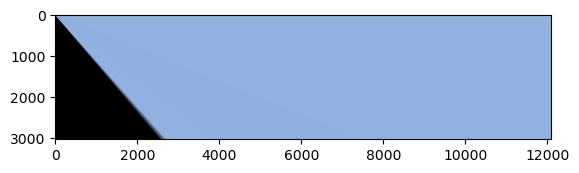

In [64]:
warpedImgq = cv2.warpPerspective(img1, H, (width, length))
plt.imshow(warpedImgq)

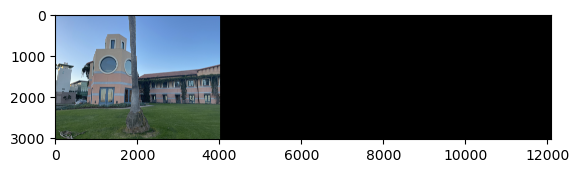

In [30]:
plt.imshow(img1)

In [31]:
pt = [1000,2500,1]
print(img1[pt[1], pt[0]])
new_pt = H @ np.array(pt)
new_pt /= new_pt[2]  # Normalize by the third coordinate
nx, ny = int(new_pt[0]), int(new_pt[1])
print(warpedImgq[ny, nx])
print(nx, ny)


[52 78 43]
[53 79 44]
1411 2852


Blend the warped img1 and img2, giving preference img1

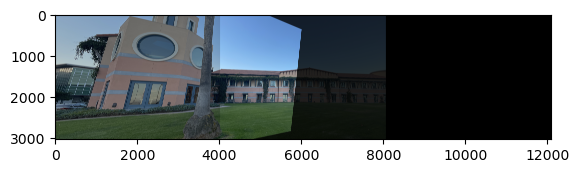

In [22]:
alpha = 0.8  # blending factor
blended_image1 = cv2.addWeighted(warpedImgq, alpha, img2, 1 - alpha, 0)
plt.imshow(blended_image1)

Repeat the same steps above to warp img3 to be aligned with img2, and then blend them together

In [23]:
img3kp = np.array([list(kpList[2][eachMatch.trainIdx].pt) for eachMatch in match2[:200]]).reshape(-1, 1, 2)
img2kp = np.array([list(kpList[1][eachMatch.queryIdx].pt) for eachMatch in match2[:200]]).reshape(-1, 1, 2)

In [24]:
H = cv2.findHomography(img3kp, img2kp, cv2.RANSAC, 5.0)[0]
length, width, channels = img3.shape

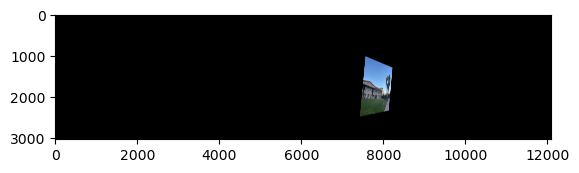

In [24]:
warpedImg3 = cv2.warpPerspective(img3, H, (width, length))
plt.imshow(warpedImg3)

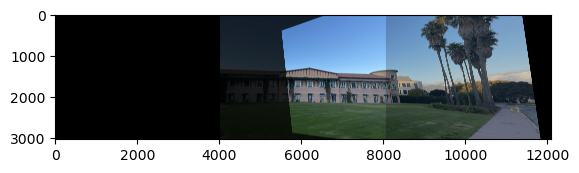

In [26]:
alpha = 0.8  # blending factor
blended_image2 = cv2.addWeighted(warpedImg3, alpha, img2, 1-alpha, 0)
plt.imshow(blended_image2)

Blend the 2 blended images together to create the final panoramic image.

In [29]:
panaromicImg = cv2.addWeighted(blended_image1, 1, blended_image2, 1, 0)

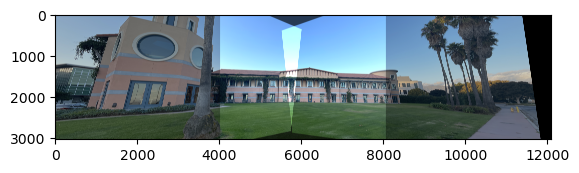

In [30]:
plt.imshow(panaromicImg)

## SIFT Algorithm Implementation

In [31]:

from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging

####################
# Global variables #
####################

logger = logging.getLogger(__name__)
float_tolerance = 1e-7


### Difference of Gaussian

In [33]:
def generateBaseImage(image, sigma, assumed_blur):
    """Generate base image from input image by upsampling by 2 in both directions and blurring
    """
    logger.debug('Generating base image...')
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  # the image blur is now sigma instead of assumed_blur

def computeNumberOfOctaves(image_shape):
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)
    """
    return int(round(log(min(image_shape)) / log(2) - 1))

def generateGaussianKernels(sigma, num_intervals):
    """Generate list of gaussian kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper.
    """
    logger.debug('Generating scales...')
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    gaussian_kernels = zeros(num_images_per_octave)  # scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

def generateGaussianImages(image, num_octaves, gaussian_kernels):
    """Generate scale-space pyramid of Gaussian images
    """
    logger.debug('Generating Gaussian images...')
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image)  # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    return array(gaussian_images)

def generateDoGImages(gaussian_images):
    """Generate Difference-of-Gaussians image pyramid
    """
    logger.debug('Generating Difference-of-Gaussian images...')
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(subtract(second_image, first_image))  # ordinary subtraction will not work because the images are unsigned integers
        dog_images.append(dog_images_in_octave)
    return array(dog_images)

### Finding Corners using Gaussian Pyramid

In [34]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid
    """
    logger.debug('Finding scale-space extrema...')
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
    """Return True if the center element of the 3x3x3 input array is strictly greater than or less than all its neighbors, False otherwise
    """
    center_pixel_value = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return all(center_pixel_value >= first_subimage) and \
                   all(center_pixel_value >= third_subimage) and \
                   all(center_pixel_value >= second_subimage[0, :]) and \
                   all(center_pixel_value >= second_subimage[2, :]) and \
                   center_pixel_value >= second_subimage[1, 0] and \
                   center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return all(center_pixel_value <= first_subimage) and \
                   all(center_pixel_value <= third_subimage) and \
                   all(center_pixel_value <= second_subimage[0, :]) and \
                   all(center_pixel_value <= second_subimage[2, :]) and \
                   center_pixel_value <= second_subimage[1, 0] and \
                   center_pixel_value <= second_subimage[1, 2]
    return False

### Localizing Extrema

In [35]:
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigenvalue_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbors
    """
    logger.debug('Localizing scale-space extrema...')
    extremum_is_outside_image = False
    image_shape = dog_images_in_octave[0].shape
    for attempt_index in range(num_attempts_until_convergence):
        # need to convert from uint8 to float32 to compute derivatives and need to rescale pixel values to [0, 1] to apply Lowe's thresholds
        first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
        pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                            second_image[i-1:i+2, j-1:j+2],
                            third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
        gradient = computeGradientAtCenterPixel(pixel_cube)
        hessian = computeHessianAtCenterPixel(pixel_cube)
        extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
        if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
            break
        j += int(round(extremum_update[0]))
        i += int(round(extremum_update[1]))
        image_index += int(round(extremum_update[2]))
        # make sure the new pixel_cube will lie entirely within the image
        if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > num_intervals:
            extremum_is_outside_image = True
            break
    if extremum_is_outside_image:
        logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
        return None
    if attempt_index >= num_attempts_until_convergence - 1:
        logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
        return None
    functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
    if abs(functionValueAtUpdatedExtremum) * num_intervals >= contrast_threshold:
        xy_hessian = hessian[:2, :2]
        xy_hessian_trace = trace(xy_hessian)
        xy_hessian_det = det(xy_hessian)
        if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
            # Contrast check passed -- construct and return OpenCV KeyPoint object
            keypoint = KeyPoint()
            keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
            keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
            keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(num_intervals))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
            keypoint.response = abs(functionValueAtUpdatedExtremum)
            return keypoint, image_index
    return None

def computeGradientAtCenterPixel(pixel_array):
    """Approximate gradient at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f'(x) is (f(x + h) - f(x - h)) / (2 * h)
    # Here h = 1, so the formula simplifies to f'(x) = (f(x + 1) - f(x - 1)) / 2
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
    dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
    ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])
    return array([dx, dy, ds])

def computeHessianAtCenterPixel(pixel_array):
    """Approximate Hessian at center pixel [1, 1, 1] of 3x3x3 array using central difference formula of order O(h^2), where h is the step size
    """
    # With step size h, the central difference formula of order O(h^2) for f''(x) is (f(x + h) - 2 * f(x) + f(x - h)) / (h ^ 2)
    # Here h = 1, so the formula simplifies to f''(x) = f(x + 1) - 2 * f(x) + f(x - 1)
    # With step size h, the central difference formula of order O(h^2) for (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
    # Here h = 1, so the formula simplifies to (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
    # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
    center_pixel_value = pixel_array[1, 1, 1]
    dxx = pixel_array[1, 1, 2] - 2 * center_pixel_value + pixel_array[1, 1, 0]
    dyy = pixel_array[1, 2, 1] - 2 * center_pixel_value + pixel_array[1, 0, 1]
    dss = pixel_array[2, 1, 1] - 2 * center_pixel_value + pixel_array[0, 1, 1]
    dxy = 0.25 * (pixel_array[1, 2, 2] - pixel_array[1, 2, 0] - pixel_array[1, 0, 2] + pixel_array[1, 0, 0])
    dxs = 0.25 * (pixel_array[2, 1, 2] - pixel_array[2, 1, 0] - pixel_array[0, 1, 2] + pixel_array[0, 1, 0])
    dys = 0.25 * (pixel_array[2, 2, 1] - pixel_array[2, 0, 1] - pixel_array[0, 2, 1] + pixel_array[0, 0, 1])
    return array([[dxx, dxy, dxs], 
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

### Computing Keypoints

In [36]:
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, num_bins=36, peak_ratio=0.8, scale_factor=1.5):
    """Compute orientations for each keypoint
    """
    logger.debug('Computing keypoint orientations...')
    keypoints_with_orientations = []
    image_shape = gaussian_image.shape

    scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))  # compare with keypoint.size computation in localizeExtremumViaQuadraticFit()
    radius = int(round(radius_factor * scale))
    weight_factor = -0.5 / (scale ** 2)
    raw_histogram = zeros(num_bins)
    smooth_histogram = zeros(num_bins)

    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  # constant in front of exponential can be dropped because we will find peaks later
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude

    for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
    orientation_max = max(smooth_histogram)
    orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
    for peak_index in orientation_peaks:
        peak_value = smooth_histogram[peak_index]
        if peak_value >= peak_ratio * orientation_max:
            # Quadratic peak interpolation
            # The interpolation update is given by equation (6.30) in https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html
            left_value = smooth_histogram[(peak_index - 1) % num_bins]
            right_value = smooth_histogram[(peak_index + 1) % num_bins]
            interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
            orientation = 360. - interpolated_peak_index * 360. / num_bins
            if abs(orientation - 360.) < float_tolerance:
                orientation = 0
            new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            keypoints_with_orientations.append(new_keypoint)
    return keypoints_with_orientations

In [37]:
def compareKeypoints(keypoint1, keypoint2):
    """Return True if keypoint1 is less than keypoint2
    """
    if keypoint1.pt[0] != keypoint2.pt[0]:
        return keypoint1.pt[0] - keypoint2.pt[0]
    if keypoint1.pt[1] != keypoint2.pt[1]:
        return keypoint1.pt[1] - keypoint2.pt[1]
    if keypoint1.size != keypoint2.size:
        return keypoint2.size - keypoint1.size
    if keypoint1.angle != keypoint2.angle:
        return keypoint1.angle - keypoint2.angle
    if keypoint1.response != keypoint2.response:
        return keypoint2.response - keypoint1.response
    if keypoint1.octave != keypoint2.octave:
        return keypoint2.octave - keypoint1.octave
    return keypoint2.class_id - keypoint1.class_id

def removeDuplicateKeypoints(keypoints):
    """Sort keypoints and remove duplicate keypoints
    """
    if len(keypoints) < 2:
        return keypoints

    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]

    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
    return unique_keypoints

def convertKeypointsToInputImageSize(keypoints):
    """Convert keypoint point, size, and octave to input image size
    """
    converted_keypoints = []
    for keypoint in keypoints:
        keypoint.pt = tuple(0.5 * array(keypoint.pt))
        keypoint.size *= 0.5
        keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)
        converted_keypoints.append(keypoint)
    return converted_keypoints

### Generate Keypoint Descriptors

In [42]:
def unpackOctave(keypoint):
    """Compute octave, layer, and scale from a keypoint
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8, scale_multiplier=3, descriptor_max_value=0.2):
    """Generate descriptors for each keypoint
    """
    logger.debug('Generating descriptors...')
    descriptors = []

    for keypoint in keypoints:
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   # first two dimensions are increased by 2 to account for border effects

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))   # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     # ensure half_width lies within image

        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

## SIFT Method

In [41]:
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image
    """
    image = image.astype('float32')
    base_image = generateBaseImage(image, sigma, assumed_blur)
    num_octaves = computeNumberOfOctaves(base_image.shape)
    gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
    gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
    dog_images = generateDoGImages(gaussian_images)
    keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
    keypoints = removeDuplicateKeypoints(keypoints)
    keypoints = convertKeypointsToInputImageSize(keypoints)
    descriptors = generateDescriptors(keypoints, gaussian_images)
    return keypoints, descriptors